# Lab Assignment Seven: Recurrent Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate a recurrent architecture and tune hyper-parameters.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela

2) Naim Barnett

3) Katie Rink

## Dataset Selection

Data Set : Twitter Sentimental analysis Dataset - https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv

## Overview and Business Understanding

From the public domain of Kaggle, we import this dataset that we think is most convinient for this lab pruproses. This was a dataaset created as a part of a university Project On Sentimental Analysis On Multi-Source Social Media Platform. These tweets were made on Narendra Modi and other Leaders as well as People's opinion towards the next Prime Minister of The Nation (In Context with General Elections Held In India - 2019). This dataset consists of around 163K tweets from the social media platform Twitter, it has two cloumns, the first column has the cleaned tweets and Comments and the Second one indicates its Sentimental Label. with Sentimental Label in the form:

{
0: Indicating it is a Neutral Tweet

1: Indicating a Postive Sentiment

-1: Indicating a Negative Tweet
}

We can create a business goal for this dataset in the following way: say we are hired by Twitter to speed up their detection for tweets that violate policies and rules. We expect tweets that have a positive sentiment and neutral tweets in general to not be violating the policies, however, negative tweets are more likely to contain words that are inappropriate and violate the codes of the platform. Thus, this classification will help in detecting the tweets that are more likely to be violating the codes of the platform (the negative tweets), and we end up with a binary classification problem more or less.

It is worth noting that we relied heavily on the professor's notebook, so everything I took from there will be cited with "(Inspired by the professor's notebook)" beforehand.

## Preparation

Defining and preparing our class variables. Describing the final dataset that is used for classification. Discussing methods of tokenization in our dataset as well as any decisions to force a specific length of sequence.

In [1]:
"""Importing all the needed packages"""
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import (GRU, LSTM, Activation, Conv1D, Dense,
                                     Dropout, Embedding, Flatten, Input,
                                     InputLayer, MaxPooling1D, concatenate)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

2022-12-14 16:33:31.175678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
"""Loading the Dataset"""
data = pd.read_csv('../../Data/Twitter_Data.csv', low_memory=False)
LOAD_STORED_MODELS = True
plt.figure(figsize=(18, 6))

# quick cleaning
data.dropna(inplace=True);
data = data.drop_duplicates()

# Specifying which datatypes you expect for each column
data['clean_text'] = data['clean_text'].astype(str)
data['category'] = data['category'].astype(int)

#Showing data
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


,clean_text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1
162976,dear rss terrorist payal gawar what about modi...,-1
162977,did you cover her interaction forum where she ...,0
162978,there big project came into india modi dream p...,0


<Figure size 1800x600 with 0 Axes>

In [3]:
# Turning our problem to a binary classification one to be consistent with our business case
print("Before replacing:")
print(data["category"].value_counts())
print('================================')
data['category'].replace([-1,0],[0,1], inplace=True)
print("After replacing:")
print(data["category"].value_counts())

Before replacing:
 1    72249
 0    55211
-1    35509
Name: category, dtype: int64
After replacing:
1    127460
0     35509
Name: category, dtype: int64


In [4]:
"""Displaying a random tweet and its label"""
idx = round(np.random.rand()*data.shape[0])
print('--------Random Tweet---------')
print(data['clean_text'][idx])
print('================================')
print('Tweet Label: ',data['category'][idx])

--------Random Tweet---------
why congress not putting strong leaders against amit shah and narendra modi kya understanding hai
Tweet Label:  1


In [5]:
# making lists of the instances and targets ready to be tokenized
instances = data["clean_text"].to_list() 
target = data["category"].to_numpy()

In [6]:
"""(Inspired by the professor's notebook)"""

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(instances)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(instances)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 113678 unique tokens. Distilled to 113678 top words.
Shape of data tensor: (162969, 1000)
Shape of label tensor: (162969, 2)
113678


Now, we have our final dataset that is ready for the sentiment classification task. We have our "X" tensor containing all the 162969 tweets, vectorized into a sequence of integers using the Keras text Tokenizer. We leave the default options of the tokenizer and the pad_sequences as we do not have massively big texts that we need to suppress or control (thanks to the limit on the character content of the tweets already imposed by Twitter :D). We also have our labels tensor as "y_ohe" in a one-hot encoded form.

Number of tweets: 162,969
Number of negative tweets: 35,509
Number of positive tweets: 127,460
Longest tweets in words: 52
99th percentile of tweets lengths: 42.0


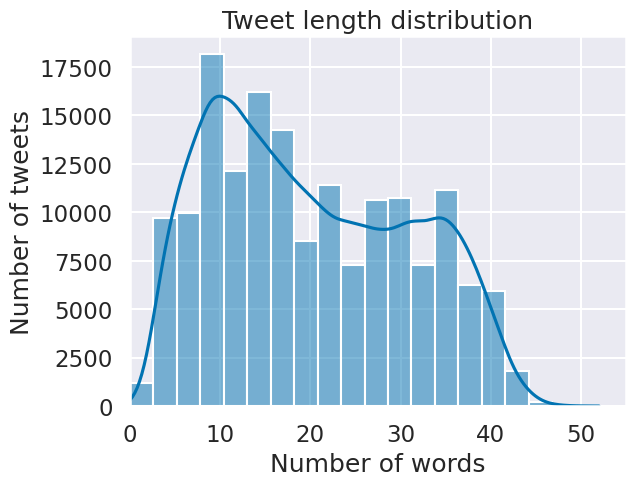

In [7]:
# print some statistics
print(f"Number of tweets: {len(data):,}")
print(f"Number of negative tweets: {len(data[data['category'] == 0]):,}")
print(f"Number of positive tweets: {len(data[data['category'] == 1]):,}")

tweet_lengths = [len(review.split()) for review in data['clean_text'].astype(str)]

# print the longest review in words
print(f"Longest tweets in words: {max(tweet_lengths)}")

# print the 99th percentile of review lengths
print(f"99th percentile of tweets lengths: {np.percentile(tweet_lengths, 99)}")

# graph the number of words in each review
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('colorblind')
\

sns.histplot(tweet_lengths, bins=20, kde=True)

plt.title('Tweet length distribution')
plt.xlabel('Number of words')
plt.ylabel('Number of tweets')
plt.xlim(0, 55)

plt.show()

X_train Shape: (130375, 1000) Label Shape: (130375, 2)


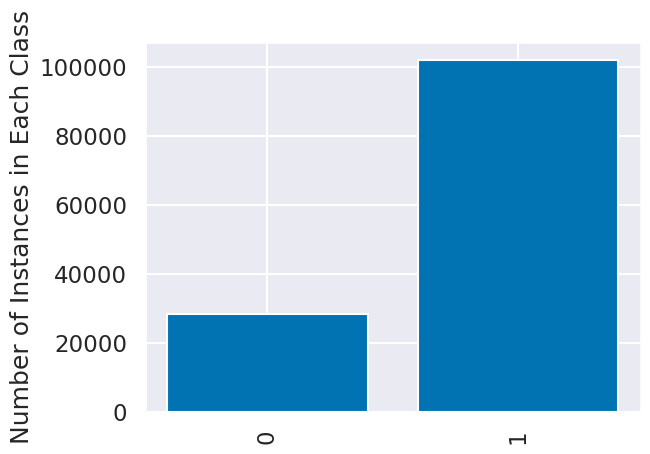

In [8]:
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=target, 
                                                            random_state=42)
NUM_CLASSES = 2

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(2)),uniq_classes)
plt.xticks(list(range(2)), rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

### Choosing and explaining what metric we will use to evaluate your algorithm’s performance.

For our business case that was already explained in the beginning of this notebook, it's more important for us to detect the negative tweets than detect the negative ones. In other words, having a false positive classification will be worse and less desirable than a false negative. Thus, we are looking to maximize the true positive out of the total predicted positives and consequently, the appropriate metric we decide to use is the "Precision" metric. 

### Choosing the method we will use for dividing our data for cross-validation

Since we have a kind of unbalanced data where one of the labels is significantly abundant than the other, we might be compelled to use Stratified 10-fold cross validation, to ensure that we have a good mirror of the original set and to also avoid having a significantly higher imbalance in during one set of cross-validation trainings. That's why we avoid using ShuffleSplits as we might end up having a severe imbalance during the training of one of the splits.

In [9]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train, y_train_ohe)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


## Modeling

Below we define a function called create_RNN() that takes in several arguments, including a name for the RNN model, the RNN_layer_type (either 'LSTM' or 'GRU'), the number of num_units, and an embedding_layer. The function uses the RNN_layer_type argument to determine which type of RNN layer to use in the model (either LSTM or GRU). It then creates a new Sequential model with the specified name and adds the embedding_layer and RNN layer to it. The RNN layer has 100 units and uses a dropout rate of 0.2. The function then adds a dense output layer with NUM_CLASSES output units and a sigmoid activation function, and compiles the model using the 'categorical_crossentropy' loss function and the 'rmsprop' optimizer. Finally, the function returns the compiled RNN model

Increasing the number of units in an RNN can allow the model to learn more complex patterns in the data, but using too many units can result in overfitting. Thus, after several attempts, I found that keeping the number of layers at around 100 prevented overfitting the best. The dropout rate is a regularization technique that helps prevent overfitting by randomly dropping out a portion of the units during training. A dropout rate of 0.2 means that 20% of the units will be dropped out during each training step. I found that any higher dropout caused generalizations to the new data to not match as well, so 20% stayed pretty consistent, while still allowing it to adapt. 

In [10]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

def create_RNN(name, RNN_layer_type, num_units, embedding_layer):
    if RNN_layer_type == 'LSTM':
        rnn = Sequential(name=name)
        rnn.add(embedding_layer)
        rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
        rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
    elif RNN_layer_type == 'GRU':
        rnn = Sequential(name=name)
        rnn.add(embedding_layer)
        rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
        rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
    else:
        raise ValueError("RNN_layer_type must be one of 'LSTM' or 'GRU'")
        
    return rnn

This function takes three arguments: x_test, y_true, and model, and then calculates the confusion matrix for the given test data and true labels using the provided model. To calculate the confusion matrix, the code first makes predictions using the model by calling model.predict(x_test). It then generates the confusion matrix using the confusion_matrix function from the sklearn.metrics module and returns it.

In [11]:
def create_confusion_matrix(X_test, y_true, model) :
    # make predictions
    if LOAD_STORED_MODELS :
        with open(f"Models/{model.name}_pred.pkl", 'rb') as file_pi:
            y_pred = pickle.load(file_pi)
    else :
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1).flatten()
        
        with open(f"Models/{model.name}_pred.pkl", 'wb') as f:
            pickle.dump(y_pred, f)
    y_true = np.argmax(y_true, axis=1).flatten()
    y_true = y_true.astype('int64')

    # generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # print confusion matrix
    return cm

Then we made a function named get_precision() that takes in two arguments: y_true, which is an array of true labels, and model, which is a Keras model. The function first loads the predicted labels (y_pred) from a pickle file using the model.name attribute, which we know will already exist because we will always run the confusion matrix which calculates it first. It then calculates the precision of the model using the Precision() method from the keras.metrics module, and returns the result as a NumPy array. This will allow us to later compare the values of precision for each model. 

In [12]:
def get_precision(y_true, model) :
    #Always run after create confusion matrix so should already exist
    with open(f"Models/{model.name}_pred.pkl", 'rb') as file_pi:
            y_pred = pickle.load(file_pi)
           
    #Get the actual predicted value instead of the probabilites
    y_true = np.argmax(y_true, axis=1).flatten()
    y_true = y_true.astype('int64')
    
    #Get precision of model
    precision = keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    
    return precision.result().numpy()

This is a function for visualizing the training and validation accuracy and loss for a Keras model. The function takes a history object as input, which is returned by the fit() method of a Keras model. The function plots the training and validation accuracy and loss. This helps understand how the model is performing during training and identify any potential overfitting or underfitting. It can also help us determine when to stop training the model to avoid overfitting.

In [13]:
def show_history(history) :
    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Then we we needed to load a pre-trained word embedding from a file and creating an embedding matrix from it. The embedding matrix is then used to initialize the embedding layer of a Keras model.

Word embeddings are numerical representations of words that capture the semantic relationships between words in a text corpus. Pre-trained word embeddings, such as GloVe, are trained on large text corpora and can be used to improve the performance of natural language processing models. In our code, the glove.6B.50d.txt file is being loaded, which contains a 50-dimensional GloVe word embedding trained on a 6 billion word corpus. The code then iterates through the lines in the file and creates a dictionary that maps each word to its corresponding embedding vector.

Next, the code creates an embedding matrix with the same shape as the vocabulary of the Keras model. The matrix is initialized with all zeros, and the code then iterates through the words in the vocabulary and replaces the corresponding row in the matrix with the pre-trained word embedding if the word is found in the dictionary. The resulting embedding matrix is then used to initialize the embedding layer of the Keras model. This allows the model to use the pre-trained word embeddings when learning the task at hand.

In [14]:
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../../Data/glove.6B.50d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index):,} word vectors.\n")

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print(f"Embedding Shape: {embedding_matrix.shape}")
print(f"Total words found: {found_words:,}")
print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")

Found 400,000 word vectors.

Embedding Shape: (113679, 50)
Total words found: 40,507
Percentage: 35.63


### Architecture 1 : LSTM

The EMBED_SIZE variable defines the size of the embedding layer, which is the dimensionality of the word vectors that will be learned by the model. This value is set to 50, which means that each word will be represented by a 50-dimensional vector.

The input_holder variable is an Input object that will be used as the input layer for the model. It is defined with a shape of (X_train.shape[1], ), where X_train is a 2D array of training data with X_train.shape[1] being the number of features.

The embedding_layer variable is an Embedding layer that will be used in the model to map words to their corresponding word vectors. The layer is defined with the number of words in the vocabulary (len(word_index) + 1), the size of the word vectors (EMBED_SIZE), the pre-trained weights for the word vectors (weights=[embedding_matrix]), the length of the input sequences (input_length=MAX_ART_LEN), and the trainable parameter set to False, which means that the word vectors will not be updated during training.

Finally, the LOAD_STORED_MODELS variable is set to True, which determines whether to load previously trained models or train new models from scratch.

In [15]:
EMBED_SIZE = 50
input_holder = Input(shape=(X_train.shape[1], ))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

The code defines two Recurrent Neural Network (RNN) models, rnn1 and rnn2, using the earlier defined create_RNN function. The rnn1 model uses a long short-term memory (LSTM) layer with 10 units, and the rnn2 model uses a LSTM layer with 25 units. Both models use the embedding_layer defined earlier as their input layer.

If the LOAD_STORED_MODELS variable is True, the code attempts to load the trained weights and training history for the rnn1 and rnn2 models from the Models directory. If the models are not found or the LOAD_STORED_MODELS variable is False, the code trains the models on the X_train and y_train_ohe data for 3 epochs with a batch size of 64, and saves the trained weights and training history to the Models directory.

After the models are trained, the code prints their summary, shows their training history, calculates their confusion matrix on the X_test and y_test_ohe data using the confusion_matrix function, and finds the precision.

2022-12-14 16:33:50.297483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 16:33:50.297639: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "RNN-LSTM-25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          5683950   
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 5,744,552
Trainable params: 60,602
Non-trainable params: 5,683,950
_________________________________________________________________
None


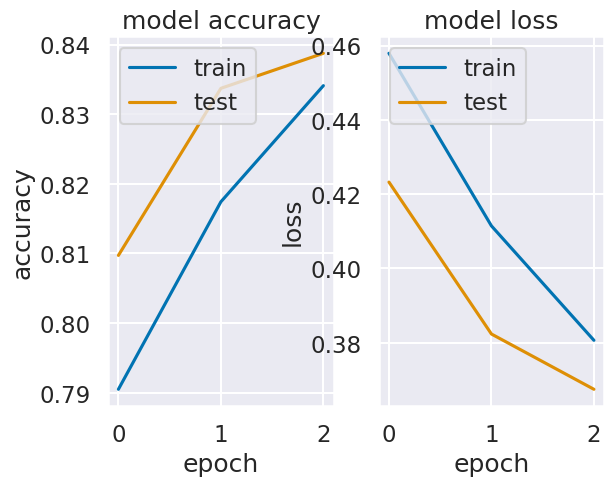

[[ 2204  4898]
 [  358 25134]]
Precision : 0.8369073
Model: "RNN-LSTM-50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          5683950   
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,744,552
Trainable params: 60,602
Non-trainable params: 5,683,950
_________________________________________________________________
None


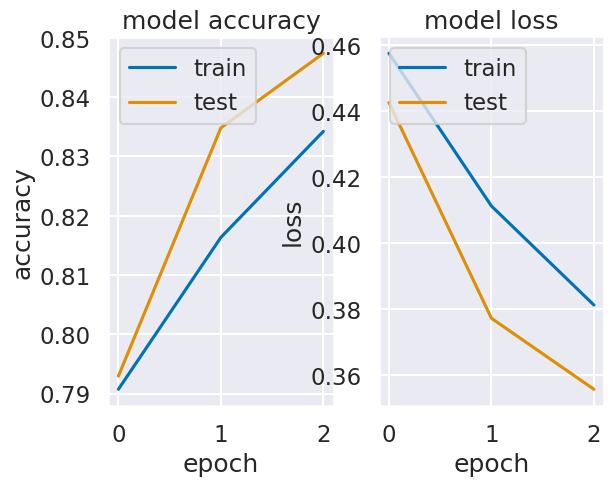

[[ 3384  3718]
 [ 1256 24236]]
Precision : 0.86699575


In [16]:
rnn1 = create_RNN('RNN-LSTM-25', 'LSTM', 10, embedding_layer)
rnn2 = create_RNN('RNN-LSTM-50', 'LSTM', 25, embedding_layer)

if LOAD_STORED_MODELS : 
    # load model 1
    rnn1.load_weights(f"Models/{rnn1.name}.h5")
    #load history
    with open(f"Models/{rnn1.name}.pkl", 'rb') as file_pi:
        history1 = pickle.load(file_pi)
        
    # load model 2
    rnn2.load_weights(f"Models/{rnn2.name}.h5")
    #load history
    with open(f"Models/{rnn2.name}.pkl", 'rb') as file_pi:
        history2 = pickle.load(file_pi)
else : 
    history1 = rnn1.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn1.save_weights(f"Models/{rnn1.name}.h5")
    # save history
    with open(f"Models/{rnn1.name}.pkl", 'wb') as f:
        pickle.dump(history1.history, f)

    print(f"Model {rnn1.name} saved")

    history2 = rnn2.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn2.save_weights(f"Models/{rnn2.name}.h5")
    # save history
    with open(f"Models/{rnn2.name}.pkl", 'wb') as f:
        pickle.dump(history2.history, f)

    print(f"Model {rnn2.name} saved")

print(rnn1.summary())
show_history(history1)
cnn1 = create_confusion_matrix(X_test, y_test_ohe, rnn1)
print(cnn1)
prec1 = get_precision(y_test_ohe, rnn1)
print("Precision :", prec1)

print(rnn2.summary())
show_history(history2)
cnn2 = create_confusion_matrix(X_test, y_test_ohe, rnn2)
print(cnn2)
prec2 = get_precision(y_test_ohe, rnn2)
print("Precision :", prec2)

### Architecture 2 : GRU

The code appears to define two more RNN models, rnn3 and rnn4, using the create_RNN function, which is assumed to be defined elsewhere in the code. The rnn3 model uses a gated recurrent unit (GRU) layer with 10 units, and the rnn4 model uses a GRU layer with 25 units. Both models use the embedding_layer defined earlier as their input layer.

If the LOAD_STORED_MODELS variable is True, the code attempts to load the trained weights and training history for the rnn3 and rnn4 models from the Models directory. If the models are not found or the LOAD_STORED_MODELS variable is False, the code trains the models on the X_train and y_train_ohe data for 3 epochs with a batch size of 64, and saves the trained weights and training history to the Models directory.

After the models are trained, the code prints their summary using the summary() method, shows their training history using the show_history function, calculates their confusion matrix on the X_test and y_test_ohe data using the confusion_matrix function, and calculates the precision. This code is similar to the code that was shown earlier, but it uses the rnn3 and rnn4 models instead of the rnn1 and rnn2 models.

Model: "RNN-GRU-25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          5683950   
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,744,552
Trainable params: 60,602
Non-trainable params: 5,683,950
_________________________________________________________________
None


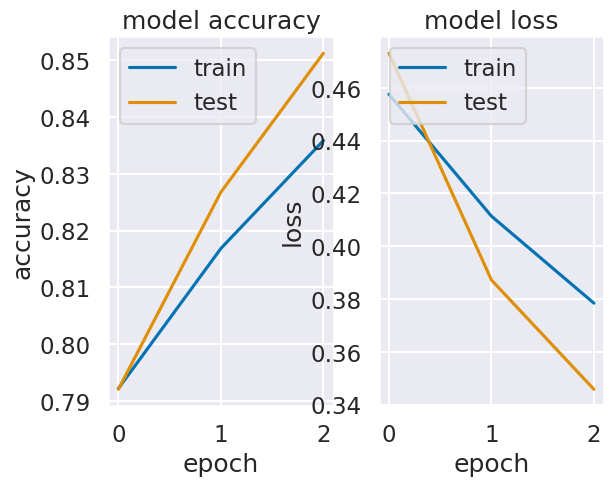

[[ 3184  3918]
 [  931 24561]]
Precision : 0.86242497
Model: "RNN-GRU-50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          5683950   
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 5,744,552
Trainable params: 60,602
Non-trainable params: 5,683,950
_________________________________________________________________
None


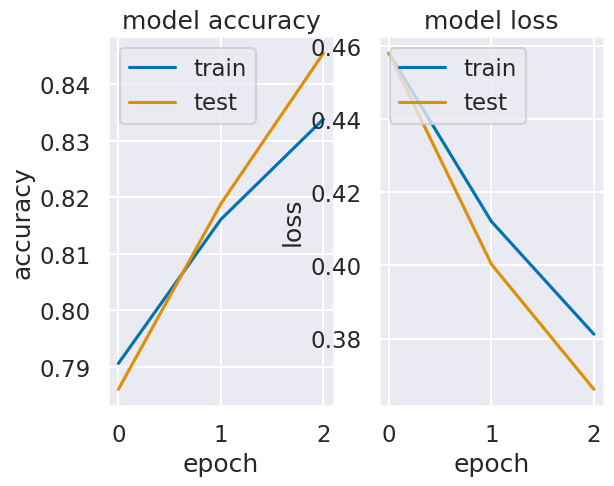

[[ 4020  3082]
 [ 1955 23537]]
Precision : 0.88421804


In [17]:
rnn3 = create_RNN('RNN-GRU-25', 'GRU', 10, embedding_layer)
rnn4 = create_RNN('RNN-GRU-50', 'GRU', 25, embedding_layer)

if LOAD_STORED_MODELS : 
    # load model 3
    rnn3.load_weights(f"Models/{rnn3.name}.h5")
    #load history
    with open(f"Models/{rnn3.name}.pkl", 'rb') as file_pi:
        history3 = pickle.load(file_pi)
    
    
    # load model 4
    rnn4.load_weights(f"Models/{rnn4.name}.h5")
    #load history
    with open(f"Models/{rnn4.name}.pkl", 'rb') as file_pi:
        history4 = pickle.load(file_pi)
else : 
    history3 = rnn3.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn3.save_weights(f"Models/{rnn3.name}.h5")
    # save history
    with open(f"Models/{rnn3.name}.pkl", 'wb') as f:
        pickle.dump(history3.history, f)

    print(f"Model {rnn3.name} saved")

    history4 = rnn4.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn4.save_weights(f"Models/{rnn4.name}.h5")
    # save history
    with open(f"Models/{rnn4.name}.pkl", 'wb') as f:
        pickle.dump(history4.history, f)

    print(f"Model {rnn4.name} saved")

print(rnn3.summary())
show_history(history3)
cnn3 = create_confusion_matrix(X_test, y_test_ohe, rnn3)
print(cnn3)
prec3 = get_precision(y_test_ohe, rnn3)
print("Precision :", prec3)

print(rnn4.summary())
show_history(history4)
cnn4 = create_confusion_matrix(X_test, y_test_ohe, rnn4)
print(cnn4)
prec4 = get_precision(y_test_ohe, rnn4)
print("Precision :", prec4)

### Comparison

Firstly, I compared all the accuracies of the models, and I found that the differences between them was minimal. This could be due to the fact that we were only able to operate on limited time constraints. 

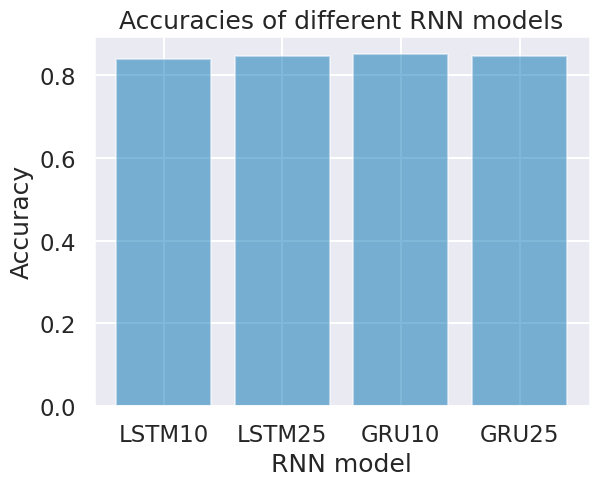

Variation 0.012486934661865234


In [18]:
# Compare accuracies
# specify the names and accuracies of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25']
accuracies = [np.max(history1['val_accuracy']), np.max(history2['val_accuracy']), np.max(history3['val_accuracy']), np.max(history4['val_accuracy'])]

# create the bar chart
plt.bar(model_names, accuracies, align='center', alpha=0.5)
plt.xlabel('RNN model')
plt.ylabel('Accuracy')
plt.title('Accuracies of different RNN models')

# show the chart
plt.show()

#print difference between min and max
print("Variation", np.max(accuracies)-np.min(accuracies))

Then I compared the precisions and found that the 10 models were slighly less precise, but overal the values were very similar. 

Variation 0.04731071


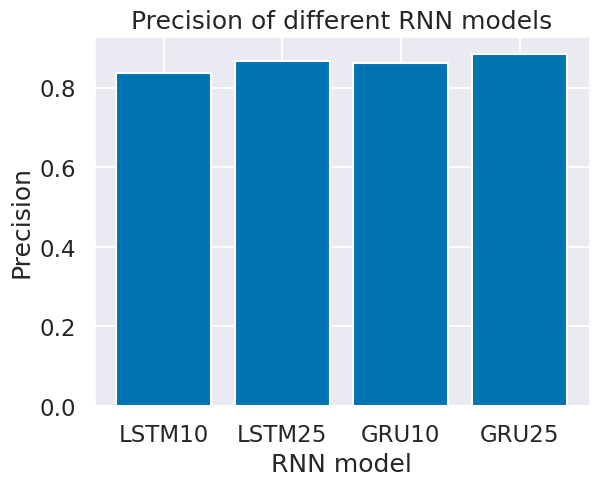

In [19]:
#Compare the Precisions
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25']
precisions = [prec1, prec2, prec3, prec4]

plt.bar(model_names, precisions)
plt.xlabel('RNN model')
plt.ylabel('Precision')
plt.title('Precision of different RNN models')

#print difference between min and max
print("Variation", np.max(precisions)-np.min(precisions))

Finally, I graphed the comparisons of False Negatives to False Positives. Unfortunately, they tend to favor False Positives.

Text(0.5, 1.0, 'Accuracies of different RNN models')

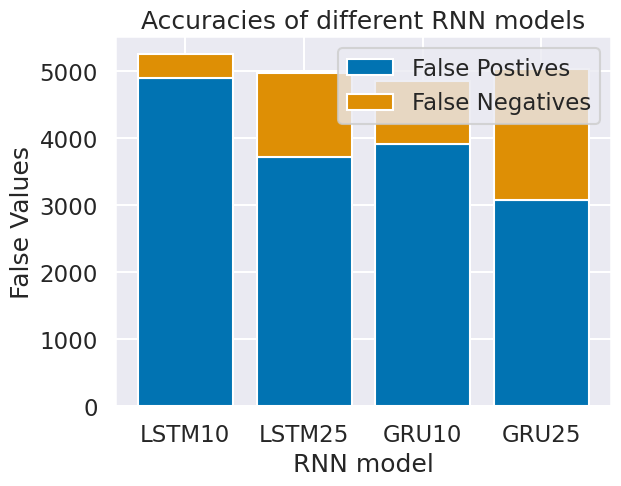

In [20]:
#Compare False Postives and False Negatives
# specify the names and values of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25',]
false_postives = [cnn1[0][1], cnn2[0][1], cnn3[0][1], cnn4[0][1]]
false_negatives = [cnn1[1][0], cnn2[1][0], cnn3[1][0], cnn4[1][0]]

# create the bar chart
plt.bar(model_names, false_postives)
plt.bar(model_names, false_negatives, bottom=false_postives)
plt.xlabel('RNN model')
plt.ylabel('False Values')
plt.legend(['False Postives', 'False Negatives'])
plt.title('Accuracies of different RNN models')

### Adding a Second Recurrent Chain

The create_RNN function defines a Keras Sequential model with either an LSTM or a GRU layer, depending on the value of the RNN_layer_type argument. The function takes four arguments: name, RNN_layer_type, num_units, and embedding_layer. The name argument specifies the name of the model, the RNN_layer_type argument specifies the type of the RNN layer that will be used in the model (either LSTM or GRU), the num_units argument specifies the number of units in the RNN layer, and the embedding_layer argument specifies the Keras Embedding layer that will be used as the input layer for the model.

The code first checks the value of the RNN_layer_type argument, and depending on whether it is LSTM or GRU, it defines a Sequential model with the specified name and adds the embedding_layer to it as the input layer. It then adds two RNN layers to the model, with the number of units specified by the num_units argument and dropout regularization to prevent overfitting. Finally, it adds a dense layer with NUM_CLASSES units and a sigmoid activation function, compiles the model with the categorical_crossentropy loss function, the rmsprop optimizer, and the accuracy metric, and returns the model. Essentially, the same model as above but with an additional recurrent chain. 

In [21]:
def create_RNN_2chain(name, RNN_layer_type, num_units, embedding_layer):
    if RNN_layer_type == 'LSTM':
        rnn = Sequential(name=name)
        rnn.add(embedding_layer)
        rnn.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        rnn.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
        rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
    elif RNN_layer_type == 'GRU':
        rnn = Sequential(name=name)
        rnn.add(embedding_layer)
        rnn.add(GRU(50,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        rnn.add(GRU(50,dropout=0.2, recurrent_dropout=0.2))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
        rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
    return rnn

Then we defined a new RNN model, rnn5, using the create_RNN function. The rnn5 model uses a GRU layer with 25 units, and it uses the embedding_layer as its input layer. It follows the same methodology as the priorly created RNN models. 

Model: "RNN-GRU-25-2Chain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          5683950   
                                                                 
 gru (GRU)                   (None, 1000, 50)          15300     
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_4 (Dense)             (None, 2)                 102       
                                                                 
Total params: 5,714,652
Trainable params: 30,702
Non-trainable params: 5,683,950
_________________________________________________________________
None


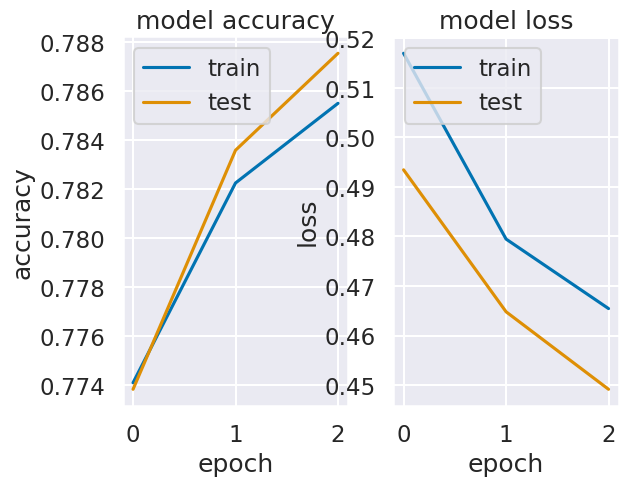

[[  624  6478]
 [  447 25045]]
Precision : 0.7944993


In [22]:
rnn5 = create_RNN_2chain('RNN-GRU-25-2Chain', 'GRU', 25, embedding_layer)

if LOAD_STORED_MODELS : 
    # load model 5
    rnn5.load_weights(f"Models/{rnn5.name}.h5")
    #load history
    with open(f"Models/{rnn5.name}.pkl", 'rb') as file_pi:
        history5 = pickle.load(file_pi)
else : 
    history5 = rnn5.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn5.save_weights(f"Models/{rnn5.name}.h5")
    # save history
    with open(f"Models/{rnn5.name}.pkl", 'wb') as f:
        pickle.dump(history5.history, f)

    print(f"Model {rnn5.name} saved")

print(rnn5.summary())
show_history(history5)
cnn5 = create_confusion_matrix(X_test, y_test_ohe, rnn5)
print(cnn5)
prec5 = get_precision(y_test_ohe, rnn5)
print("Precision :", prec5)

### Compare all RNNs

To compare all of the above models, I can see that they all begin to converge, however, they need a few more epochs to fully converge. To get more of an analysis, I graphed the accuracies, and I found that adding a second chain caused a lower value in accuracy. This may be due to the fact that because of time constraints we had to lower the number layers. However, accuracy tends to maintain around 80%, which is standardly good accuracy. 

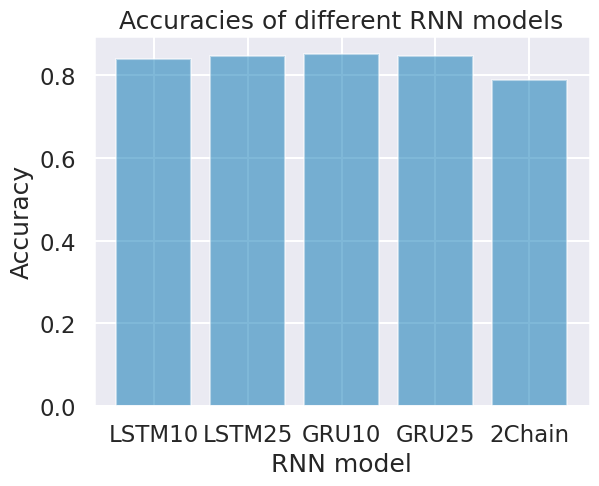

In [23]:
# Compare accuracies
# specify the names and accuracies of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', '2Chain']
accuracies = [np.max(history1['val_accuracy']), np.max(history2['val_accuracy']), np.max(history3['val_accuracy']), np.max(history4['val_accuracy']), np.max(history5['val_accuracy'])]

# create the bar chart
plt.bar(model_names, accuracies, align='center', alpha=0.5)
plt.xlabel('RNN model')
plt.ylabel('Accuracy')
plt.title('Accuracies of different RNN models')

# show the chart
plt.show()

Consistent with the accuracies, we saw the 2 chain produce a slighly lower precision than the other values. 

Text(0.5, 1.0, 'Precision of different RNN models')

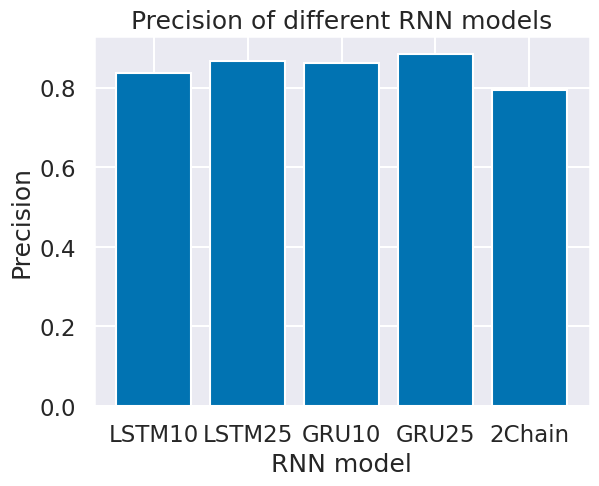

In [24]:
#Compare the Precisions
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', '2Chain']
precisions = [prec1, prec2, prec3, prec4, prec5]

plt.bar(model_names, precisions)
plt.xlabel('RNN model')
plt.ylabel('Precision')
plt.title('Precision of different RNN models')

Once again, I graphed the false postives to false negatives. However, I found that False Positives still remained the most prevelant. 

Text(0.5, 1.0, 'Accuracies of different RNN models')

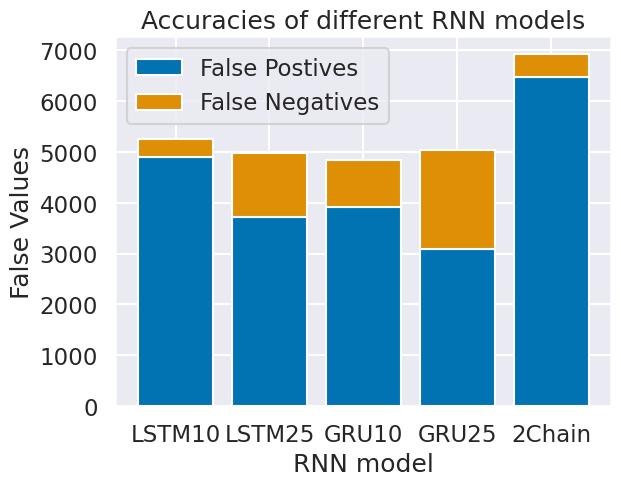

In [25]:
#Compare False Postives and False Negatives
# specify the names and values of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', '2Chain']
false_postives = [cnn1[0][1], cnn2[0][1], cnn3[0][1], cnn4[0][1], cnn5[0][1]]
false_negatives = [cnn1[1][0], cnn2[1][0], cnn3[1][0], cnn4[1][0], cnn5[1][0]]

# create the bar chart
plt.bar(model_names, false_postives)
plt.bar(model_names, false_negatives, bottom=false_postives)
plt.xlabel('RNN model')
plt.ylabel('False Values')
plt.legend(['False Postives', 'False Negatives'])
plt.title('Accuracies of different RNN models')

## Exceptional Work

### ConceptNet Numberbatch

ConceptNet Numberbatch is an embedding method that uses a large amount of external knowledge from various sources to produce high-quality word vectors that capture the meanings of words in a way that is useful for natural language processing tasks. This can make it particularly well-suited for applications that require a deep understanding of the meanings of words and their relationships to each other.

GloVe is a widely-used word embedding method that uses a large corpus of text to learn vector representations of words. It is particularly effective at capturing the syntactic and semantic relationships between words, which can be useful for tasks such as language translation and text generation.

So to compare which one proves the better results for us, we created another embedded layer with numberbatch rather than GloVe using the same method as prior. 

In [ ]:
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../../Data/numberbatch-en-19.08.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index):,} word vectors.\n")

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print(f"Embedding Shape: {embedding_matrix.shape}")
print(f"Total words found: {found_words:,}")
print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")

We then reran the RNN we found to be best priorly, so that we can compare. All the same settings were used as were priorly, and then we generated the history, confusion matrix, and precision. 

In [ ]:
rnn6 = create_RNN('RNN-GRU-25-numbat', 'GRU', 25, embedding_layer)

if LOAD_STORED_MODELS : 
    # load model 5
    rnn6.load_weights(f"Models/{rnn6.name}.h5")
    #load history
    with open(f"Models/{rnn6.name}.pkl", 'rb') as file_pi:
        history6 = pickle.load(file_pi)
else : 
    history6 = rnn6.fit(X_train, y_train_ohe, epochs=3, batch_size=4096, validation_data=(X_test, y_test_ohe))
    # Save model
    rnn6.save_weights(f"Models/{rnn6.name}.h5")
    # save history
    with open(f"Models/{rnn6.name}.pkl", 'wb') as f:
        pickle.dump(history6.history, f)

    print(f"Model {rnn6.name} saved")

print(rnn6.summary())
show_history(history6)
cnn6 = create_confusion_matrix(X_test, y_test_ohe, rnn6)
print(cnn6)
prec6 = get_precision(y_test_ohe, rnn6)
print("Precision :", prec6)

### Comparisons

In [ ]:
# Compare accuracies
# specify the names and accuracies of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', 'Chain', 'Batch']
accuracies = [np.max(history1['val_accuracy']), np.max(history2['val_accuracy']), np.max(history3['val_accuracy']), np.max(history4['val_accuracy']), np.max(history5['val_accuracy']), np.max(history6['val_accuracy'])]

# create the bar chart
plt.bar(model_names, accuracies, align='center', alpha=0.5)
plt.xlabel('RNN model')
plt.ylabel('Accuracy')
plt.title('Accuracies of different RNN models')

# show the chart
plt.show()

#Compare Accuracies
print("Differences between GRU25 with Different Embeddings : ",  abs(np.max(history4['val_accuracy'])- np.max(history6['val_accuracy'])))

In [ ]:
#Compare the Precisions
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', '2Chain', 'NumberBatch']
precisions = [prec1, prec2, prec3, prec4, prec5, prec6]

plt.bar(model_names, precisions)
plt.xlabel('RNN model')
plt.ylabel('Precision')
plt.title('Precision of different RNN models')

print("Differences between GRU25 with Different Embeddings : ", abs(prec4-prec6))

In [ ]:
#Compare False Postives and False Negatives
# specify the names and values of the RNN models
model_names = ['LSTM10', 'LSTM25','GRU10', 'GRU25', '2Chain', 'NumberBatch']
false_postives = [cnn1[0][1], cnn2[0][1], cnn3[0][1], cnn4[0][1], cnn5[0][1], cnn6[0][1]]
false_negatives = [cnn1[1][0], cnn2[1][0], cnn3[1][0], cnn4[1][0], cnn5[1][0], cnn5[1][0]]

# create the bar chart
plt.bar(model_names, false_postives)
plt.bar(model_names, false_negatives, bottom=false_postives)
plt.xlabel('RNN model')
plt.ylabel('False Values')
plt.legend(['False Postives', 'False Negatives'])
plt.title('Accuracies of different RNN models')